In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
import numpy as np
import keras
from keras import backend as K


In [13]:
import Spectrum
import Dataset
import Model


In [7]:
def show(img):
    plot.imshow(Dataset.to_image(img))


In [14]:
cgan = Model.CycleGAN()


In [18]:
batch_size = 4
mb = Dataset.minibatch(batch_size)


In [19]:
import random

class ImagePool:
    def __init__(self, size=200):
        self.size = size
        self.n = 0
        self.images = []

    def replace(self, images):
        new_images = []
        for image in images:
            if self.n < self.size:
                self.n += 1
                self.images.append(image)
                new_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    i = random.randint(0, self.size - 1)
                    tmp = self.images[i]
                    self.images[i] = image
                    new_images.append(tmp)
                else:
                    new_images.append(image)
        return np.stack(new_images, axis=0)



In [20]:
fake_A_pool = ImagePool()
fake_B_pool = ImagePool()
target = np.zeros((batch_size, 1))



In [28]:

epoch, A, B = next(mb)


In [24]:
K.learning_phase()

<tf.Tensor 'keras_learning_phase:0' shape=() dtype=bool>

In [29]:
tmp_fake_A = K.function([cgan.net_B2A_gen.inputs[0], K.learning_phase()], [cgan.net_B2A_gen.outputs[0]])([A,1])[0]
tmp_fake_B = K.function([cgan.net_A2B_gen.inputs[0], K.learning_phase()], [cgan.net_A2B_gen.outputs[0]])([B,1])[0]
fake_b = fake_B_pool.replace(tmp_fake_B)
fake_a = fake_A_pool.replace(tmp_fake_A)
cgan.train_gen.train_on_batch([A, B], target)
cgan.train_disc_A.train_on_batch([A, fake_a], target)
cgan.train_disc_B.train_on_batch([B, fake_b], target)


/home/gurer/gpuenv/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0.4486245

In [33]:
for i in range(100):
    epoch, A, B = next(mb)
    print(epoch)

    tmp_fake_A = K.function([cgan.net_B2A_gen.inputs[0], K.learning_phase()], [cgan.net_B2A_gen.outputs[0]])([A,1])[0]
    tmp_fake_B = K.function([cgan.net_A2B_gen.inputs[0], K.learning_phase()], [cgan.net_A2B_gen.outputs[0]])([B,1])[0]
    fake_b = fake_B_pool.replace(tmp_fake_B)
    fake_a = fake_A_pool.replace(tmp_fake_A)
    cgan.train_gen.train_on_batch([A, B], target)
    cgan.train_disc_A.train_on_batch([A, fake_a], target)
    cgan.train_disc_B.train_on_batch([B, fake_b], target)


1


/home/gurer/gpuenv/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [59]:
ga=np.array([Dataset.read_rgb('image_rgb/119')])

def experiment(img):
    img2 = cgan.net_A2B_gen.predict(img)
    img3 = cgan.net_B2A_gen.predict(img2)
    return img2,img3

x = experiment(ga)


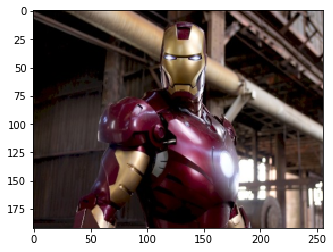

In [60]:
show(ga[0])

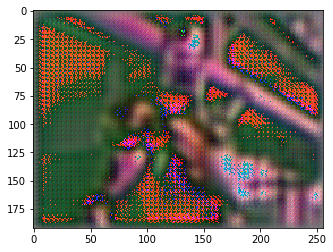

In [61]:
show(x[0][0])

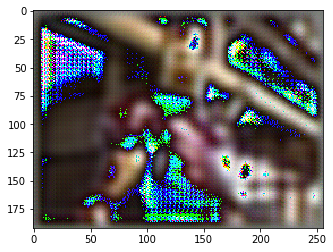

In [62]:
show(x[1][0])

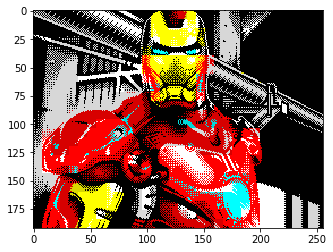

In [63]:
g = Dataset.read_scr('image_scr/119.scr')
show(g)